<a id='contents'></a>
## Table of Contents

### [I: Business Understanding](#bus)
### [II: Dependencies](#dep)
### [III: Data Understanding](#dat)
### [IV: Data Wrangling](#datw)
  ##### [1. Missing data](#datw1)
  ##### [2. Dummy data](#datw2)
  ##### [3. Missing data again. After handling dummy values](#datw3)
  ##### [4. Data Labelling IDs](#datw4)
  ##### [5. Data types](#datw5)
  ##### [6. Merge dataframes](#datw6)
### [V: Exploratory Analysis](#ea)
  ##### [1. Describe on user data](#ea1)
  ##### [2. Distribution of User Data by demographics variables](#ea2)
  ##### [3. Distribution of Event Data](#ea3)
  ##### [4. Distribution of Offer type](#ea4)
  ##### [5. Data Processing: Filter only offer received](#ea5)
  ##### [6. Distribution of Offers Received by Each Customer](#ea6)
  ##### [7. Data Processing: Create columns of success or loss of Offers sent](#ea7)
  ##### [8. How many offers were sent out, viewed and completed?](#ea8)
  ##### [9. What type of offer has the best rate of completion?](#ea9)
  ##### [10. What platform has the best rate of completion?](#ea10)
  ##### [11. What offer has the best rate of completion?](#ea11)
  ##### [12. Data Processing: Create columns of segmentations of Age and Income](#ea12)
  ##### [13. Is there any relationship between demographic variables and rate of completion?](#ea13)
### [VI: Build a ML model to predict offer success](#ml)
  ##### [1. Data Processing](#ml1)
  ##### [2. Modellings](#ml2)
  ##### [3. Building the model of ML: pipeline and gridsearch](#ml3)
  ##### [4. Evaluating the model](#ml4)
  ##### [5. Saving the model](#ml5)
  ##### [6. Running all models](#ml6)
  ##### [7. Choosing the model](#ml7)
  ##### [8. Feature Importance](#ml8)
  ##### [9. Probability Offer Success](#ml9)
### [VII: Conclusion](#summ)

-----------------------------------------------------------------------------------------------------------------------

## <a id="bus">I: Business Understanding</a>

# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Target

**For this project I am interestested in building a machine learning model to predict offer success.**

<a href='#contents'>**Go to Table of Contents**</a>

## <a id="dep">II: Dependencies</a>

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
%matplotlib inline

sns.set()

<a href='#contents'>**Go to Table of Contents**</a>

## <a id="dat">III: Data Understanding</a>

## Data Understanding

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### portfolio

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [7]:
portfolio.id.is_unique

True

The portfolio has the column id with unique values, which is the type of offer.

The dataframe has no missing values. But, the column channels has a list of variables, it will have to be treated. After treatment, it will become in binary values.

### profile

In [8]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [9]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [10]:
profile.shape

(17000, 5)

In [11]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [13]:
profile.id.is_unique

True

The profile has the column **id with unique values**, which is the user id.

The dataframe has missing values in **gender** and **income**, that that need to be analysed.

### transcript

In [14]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [15]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
transcript.shape

(306534, 4)

In [17]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


The **transcript is the fact table**. Because of this, it doesn't have an ID column.

The dataframe has **no missing values**. But there is a column with dictionaries, which will be treated.

<a href='#contents'>**Go to Table of Contents**</a>

## <a id="datw">IV: Data Wrangling</a>

### <a id="datw1">1. Missing data</a>

In [19]:
all_dfs = [profile]

In [20]:
def show_missing_values(dfs):
    
    '''
    Get the number and percent of null values of all dataframes.
    
    INPUT: 
    dfs: list of dataframes
    
    OUTPUT: 
    None
    '''
    
    for df in dfs:
        df_null_values = df.isnull().sum().reset_index()
        
        df_null_values.columns = ['column', 'n_missing_values']
        
        df_null_values['pct_missing'] = np.round(100 * df_null_values.n_missing_values / df.shape[0], 2)
        
        print(df_null_values)
        print('\n')

In [21]:
show_missing_values(all_dfs)

             column  n_missing_values  pct_missing
0            gender              2175        12.79
1               age                 0         0.00
2                id                 0         0.00
3  became_member_on                 0         0.00
4            income              2175        12.79




As the table above shows, the **gender and income have 12.79% of null values**. Still it is a high percentage of data. We can not keep them in the dataframe, and even input wrong values.

Considering profile is a dimension table, the handling must be in fact table too, called transcript. So, in the notebook below, they are removed.

First, in fact table, after in dimension.


In [22]:
def remove_events_related_missing(df_dimension, column_id_dimension, column_null_values_dimension, df_fact, column_id_fact):
    '''
    Remove rows of the fact table that are null in dimension table.
    For example: if you have a missing value in a fact table, probably you have to remove in a table fact 
    (events of these users).
    This function is useful for situation.
    
    INPUT:
    df_dimension: dataframe pandas
    column_id_dimension: the id column of dimension
    column_null_values_dimension: search the missing values
    df_fact: df_fact that have to remove the ids with missing values
    column_id_fact: column to join with column_id_dimension
    
    OUTPUT:
    df_fact cleans
    '''
    # get number of total rows (initial df_fact)
    number_of_rows_previous_df = df_fact.shape[0]
    
    # get null values of column_null_values_dimension. return column_id_dimension with null values
    id_missing_dimension = df_dimension[df_dimension[column_null_values_dimension].isnull()][column_id_dimension].values 
    
    # search by the user. and, get index to drop of events of them
    related_fact_missing = df_fact[df_fact[column_id_fact].isin(id_missing_dimension)].index.values 

    
    df_fact.drop(related_fact_missing, inplace=True) # drop events based on index, faster way

    number_of_rows_current_df = df_fact.shape[0]
    number_of_rows_removed = number_of_rows_previous_df-number_of_rows_current_df
    
    print('Number of removed rows {:,}'.format(number_of_rows_removed))
    percent_removed_rows = number_of_rows_removed/number_of_rows_previous_df
    print('Percent of removed rows {:,.2f}%'.format(percent_removed_rows*100))   
    print('\nShape: {}'.format(df_fact.shape))
    
    return df_fact

In [23]:
transcript = remove_events_related_missing(profile, 'id', 'gender', transcript, 'person')

Number of removed rows 33,772
Percent of removed rows 11.02%

Shape: (272762, 4)


The number of rows removed in fact table is near of the missing values in the dimension table.

In [24]:
def remove_null_values(df, columns):
    '''
    Remove rows of dataframe that are null, with the columns specified. Print how the dataframe is after cleaning, showing
    the dataset, remaining columns with null values and count of them, finally the number of removed rows.
    
    INPUT:
    df: dataframe pandas
    columns (list): the columns that can't have null values. These columns are used as subset on dropna method.
    
    OUTPUT:
    df pandas cleans
    '''
    
    print('Remove null values...')
    df_without_null_values = df.dropna(subset=columns,axis=0)
    
    print('Columns with null values: \n{}\n'.format(list(df.columns[df_without_null_values.isnull().sum()>0])))
    print('Count of null values per column: \n {}\n '.format(np.sum(df_without_null_values.isnull())))
    
    number_of_rows_previous_df = df.shape[0]
    number_of_rows_current_df = df_without_null_values.shape[0]
    
    number_of_rows_removed = number_of_rows_previous_df-number_of_rows_current_df
    
    print('Number of removed rows {:,}'.format(number_of_rows_removed))

    percent_removed_rows = (number_of_rows_previous_df-number_of_rows_current_df)/number_of_rows_previous_df
    print('Percent of removed rows {:,.2f}%'.format(percent_removed_rows*100))
    
    print('\nShape: {}'.format(df_without_null_values.shape))
    
    return df_without_null_values

In [25]:
profile = remove_null_values(profile, ['income', 'gender'])

Remove null values...
Columns with null values: 
[]

Count of null values per column: 
 gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64
 
Number of removed rows 2,175
Percent of removed rows 12.79%

Shape: (14825, 5)


With the table above, all null values in gender is in income too. It's a good news, because less registers are lost.

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="datw2">2. Dummy data</a>

According with the exploratory analisys, the column channels of portfolio data and the column value of transcript dataframe.

In [26]:
def get_list_of_dummies_in_column(df, column):
    '''
    Get dumies of columns with a list. Remove the old column, with list of dummies variables.
    
    INPUT: 
    df (dataframe pandas) df with dummies variables
    column (str) column with dummies variables
    
    Output: 
    df (dataframe pandas) df treated
    '''
    
    dummies_variables = df[column].str.join('|').str.get_dummies()
    df = df.join(dummies_variables)
    df = df.drop([column], axis=1)
    return df

In [27]:
portfolio = get_list_of_dummies_in_column(portfolio, 'channels')
portfolio.head(3)

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1


In [28]:
def get_keys(df, column):
    '''
    Get unique keys of a dict, that is in a dataframe pandas.
    
    INPUT: 
    df (dataframe pandas) df with dictionaries
    column (str) column with dictionaries
    
    OUTPUT: 
    dictionary with unique values
    '''    
    l = []
    
    for i in df[column]:
        
        for key in i.keys():
            key_string = key
            l.append(key_string)
           
    unique_keys = set(l)
    #print(unique_keys)
    
    return unique_keys

In [29]:
unique_keys = get_keys(transcript, 'value')

In [30]:
def create_columns_and_input_values(df, unique_keys, old_column):
    '''
    Parse a column with dict in a dataframe pandas. Treat the column with dicts, and transform them in columns. Drop old column
    in the end.
    
    INPUT: 
    df (dataframe pandas) - with dictionaries
    old_column (str) - fill with dictionaries
    unique_keys (dict) - uniques values, create the columns
    
    OUTPUT: 
    df dictionary with unique values  
    '''  
    for key in unique_keys:
        
        if ' ' not in key: # to skip duplicate key with space. ex.: 'offer id'
            
            df[key] = df[old_column].apply(lambda dictionary: dictionary[key] if key in dictionary # get dict val for examples without space
                                           
                                                              else (dictionary[key.replace('_', ' ')] if key.replace('_', ' ') in dictionary # trying to get value of 'offer id', only with space
                                                                 
                                                                    else np.NaN)) # val is nan if key is not in dict
    df = df.drop([old_column], axis=1)
            
    return df

In [31]:
transcript = create_columns_and_input_values(transcript,unique_keys, 'value')
transcript.head(3)

,person,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d


In [32]:
def get_dummies_keep_column(df, column):
    '''
    Get dummies and keep the column original column
    
    INPUT:
    df (dataframe pandas): dataframe with column to get dummy
    column: column to get dummies
        
    OUTPUT:
    df_final (dataframe pandas): dataframe with dummies treated
    '''
    
    dum = pd.get_dummies(df, columns=[column])
    df = df[[column]]
    df_final = pd.concat([df, dum], axis=1) 
    
    return df_final

In [33]:
profile = get_dummies_keep_column(profile, 'gender')
profile.head(2)

,gender,age,id,became_member_on,income,gender_F,gender_M,gender_O
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0


In [34]:
portfolio = get_dummies_keep_column(portfolio, 'offer_type')
portfolio.head(2)

,offer_type,reward,difficulty,duration,id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,bogo,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,bogo,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0


<a href='#contents'>**Go to Table of Contents**</a>

### <a id="datw3">3. Missing data again. After handling dummy values</a>

In [35]:
show_missing_values([transcript])

     column  n_missing_values  pct_missing
0    person                 0         0.00
1     event                 0         0.00
2      time                 0         0.00
3    amount            148805        54.55
4    reward            240318        88.11
5  offer_id            123957        45.45




In [36]:
transcript.groupby("event").count()

,person,time,amount,reward,offer_id
event,,,,,
offer completed,32444,32444,0,32444,32444
offer received,66501,66501,0,0,66501
offer viewed,49860,49860,0,0,49860
transaction,123957,123957,123957,0,0


The count function on groupby counts all values diferents of null.

It's important to have the same values to person and time, since this is the key of event. It's what the table shows above.

Let's analysis the events:
- **offer completed: it's ok to have null values in amount. And, it have all reward;**
- **offer received: only need to have person, time and offer_id;**
- **offer viewed: only need to have person, time and offer_id; and**
- **transaction: only need to have person, time and amount.**


As we can see, the transaction are the events when customers are spending money, only this. Offer completed always has a reward. And, the offer received and offer viewed has the offer id.

In [37]:
transcript = transcript.fillna(0)

For avoiding problems of encoding, we filled missing values with 0.

In [38]:
transcript.isnull().sum()

person      0
event       0
time        0
amount      0
reward      0
offer_id    0
dtype: int64

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="datw4">4. Data Labelling IDs</a>

In [39]:
def label_id(df, old_column, new_column, delete_old_column= False):
    """
    This function will label unique values as string or other type to unique integers. Delete old column.
    
    INPUT: 
    df (dataframe pandas): df to be labeled whose values are to be changed
    old_column (str): transcript column to be labeled whose values are to be changed
    new_column (str): name of the new column with unique integers
    
    OUTPUT:
    df (dataframe pandas): df with "new_column" labeled
     
    """    
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df[old_column]:
        
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        email_encoded.append(coded_dict[val])
    
    if delete_old_column == True:
        del df[old_column]
    df[new_column] = email_encoded 
    
    return df

In [40]:
portfolio

,offer_type,reward,difficulty,duration,id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,bogo,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,bogo,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,informational,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,bogo,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,discount,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,discount,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,discount,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,informational,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,bogo,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,discount,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [41]:
portfolio = label_id(portfolio, 'id', 'portfolio_id')
print(portfolio.portfolio_id.is_unique)
portfolio

True


,offer_type,reward,difficulty,duration,id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,portfolio_id
0,bogo,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,1
1,bogo,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,2
2,informational,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1,3
3,bogo,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0,4
4,discount,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0,5
5,discount,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0,6
6,discount,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0,7
7,informational,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1,8
8,bogo,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,9
9,discount,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0,10


In [42]:
profile = label_id(profile, 'id', 'profile_id')
print(profile.profile_id.is_unique)
profile.head(2)

True


,gender,age,id,became_member_on,income,gender_F,gender_M,gender_O,profile_id
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1,0,0,1
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1,0,0,2


<a href='#contents'>**Go to Table of Contents**</a>

### <a id="datw5">5. Data types</a>

In [43]:
all_dfs = [portfolio, profile, transcript]


def get_data_types_dfs(all_dfs):
    '''
    Print info of dataframes, which contains the datatype
    
    INPUT:
    all_dfs (list): list of dataframes to print info
    '''
    for df in all_dfs:
        print(df.info())
        print('\n')

In [44]:
get_data_types_dfs(all_dfs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   offer_type                10 non-null     object
 1   reward                    10 non-null     int64 
 2   difficulty                10 non-null     int64 
 3   duration                  10 non-null     int64 
 4   id                        10 non-null     object
 5   email                     10 non-null     int64 
 6   mobile                    10 non-null     int64 
 7   social                    10 non-null     int64 
 8   web                       10 non-null     int64 
 9   offer_type_bogo           10 non-null     uint8 
 10  offer_type_discount       10 non-null     uint8 
 11  offer_type_informational  10 non-null     uint8 
 12  portfolio_id              10 non-null     int64 
dtypes: int64(8), object(2), uint8(3)
memory usage: 958.0+ bytes
None


<class 'pandas.c

In [45]:
# Convert `became_member_on` that is integer to datetime
profile['became_member_on'] = pd.to_datetime(profile.became_member_on.astype(str))

# Create a column with year of sign in
profile['became_member_on_year'] = profile.became_member_on.dt.year

# Convert `became_member_on` that in days as member of the user. The count of days is since the max date.
profile['days_as_member'] = (profile.became_member_on.max() - profile.became_member_on).dt.days

profile.head(2)

,gender,age,id,became_member_on,income,gender_F,gender_M,gender_O,profile_id,became_member_on_year,days_as_member
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1,0,0,1,2017,376
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1,0,0,2,2017,443


In [46]:
# Convert `reward` that is float to int
transcript.reward = transcript.reward.astype('int64')

In [47]:
get_data_types_dfs(all_dfs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   offer_type                10 non-null     object
 1   reward                    10 non-null     int64 
 2   difficulty                10 non-null     int64 
 3   duration                  10 non-null     int64 
 4   id                        10 non-null     object
 5   email                     10 non-null     int64 
 6   mobile                    10 non-null     int64 
 7   social                    10 non-null     int64 
 8   web                       10 non-null     int64 
 9   offer_type_bogo           10 non-null     uint8 
 10  offer_type_discount       10 non-null     uint8 
 11  offer_type_informational  10 non-null     uint8 
 12  portfolio_id              10 non-null     int64 
dtypes: int64(8), object(2), uint8(3)
memory usage: 958.0+ bytes
None


<class 'pandas.c

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="datw6">6. Merge dataframes</a>

In [51]:
transcript = transcript.merge(portfolio, left_on = ['offer_id'], right_on = ['id'], how='left')
transcript = transcript.merge(profile, left_on = ['person'], right_on = ['id'], how='left')

In [52]:
transcript = transcript.drop(['reward_y', 'id_x', 'id_y', 'offer_id', 'person'], axis=1)
transcript.head(2)

,event,time,amount,reward_x,offer_type,difficulty,duration,email,mobile,social,...,gender,age,became_member_on,income,gender_F,gender_M,gender_O,profile_id,became_member_on_year,days_as_member
0,offer received,0,0.0,0,bogo,5.0,7.0,1.0,1.0,0.0,...,F,75,2017-05-09,100000.0,1,0,0,2,2017,443
1,offer received,0,0.0,0,discount,10.0,7.0,1.0,1.0,0.0,...,M,68,2018-04-26,70000.0,0,1,0,3,2018,91


In [53]:
transcript = transcript.rename(columns={"reward_x": "reward"})
transcript.head(2)

,event,time,amount,reward,offer_type,difficulty,duration,email,mobile,social,...,gender,age,became_member_on,income,gender_F,gender_M,gender_O,profile_id,became_member_on_year,days_as_member
0,offer received,0,0.0,0,bogo,5.0,7.0,1.0,1.0,0.0,...,F,75,2017-05-09,100000.0,1,0,0,2,2017,443
1,offer received,0,0.0,0,discount,10.0,7.0,1.0,1.0,0.0,...,M,68,2018-04-26,70000.0,0,1,0,3,2018,91


<a href='#contents'>**Go to Table of Contents**</a>

## <a id="ea">V: Exploratory Analysis </a>

### <a id="ea1">1. Describe on user data</a>

In [54]:
profile.describe()

,age,income,gender_F,gender_M,gender_O,profile_id,became_member_on_year,days_as_member
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,0.413423,0.572277,0.014300,7413.000000,2016.620169,522.478988
std,17.383705,21598.299410,0.492464,0.494765,0.118729,4279.753206,1.198245,419.205158
min,18.000000,30000.000000,0.000000,0.000000,0.000000,1.000000,2013.000000,0.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000,3707.000000,2016.000000,208.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000,7413.000000,2017.000000,358.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000,11119.000000,2017.000000,797.000000
max,101.000000,120000.000000,1.000000,1.000000,1.000000,14825.000000,2018.000000,1823.000000


The function describe above is very useful, we can take some insights. They are:
- **75% of customers are over 42 years old. And the mean is 54.39;**
- **65,404.99 is the mean of income, and it is near to median which is 64,000.00;**
- **About gender, men represent 57.23%, women 41.34% and other 1.43%; and**
- **The sign up year, even with 6 years of data. The median is concentrated on the last two years.**
    

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ea2">2. Distribution of User Data by demographics variables</a>

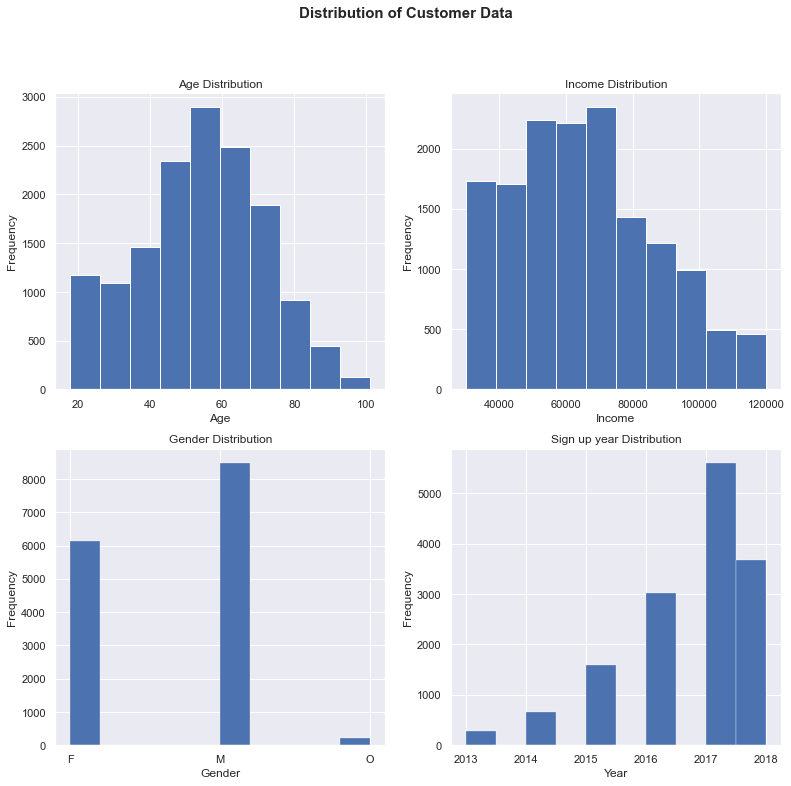

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(13, 12))
fig.suptitle('Distribution of Customer Data', fontsize=15, weight='bold')


plt.subplot(2, 2, 1)
plt.hist(profile['age']);
plt.title("Age Distribution");
plt.xlabel("Age");
plt.ylabel("Frequency");

plt.subplot(2, 2, 2)
plt.hist(profile['income']);
plt.style.use('seaborn')
plt.title("Income Distribution");
plt.xlabel("Income");
plt.ylabel("Frequency");

plt.subplot(2, 2, 3)
plt.hist(profile['gender'])
plt.title("Gender Distribution");
plt.xlabel("Gender");
plt.ylabel("Frequency");

plt.subplot(2, 2, 4)
plt.hist(profile['became_member_on_year'])
plt.title("Sign up year Distribution");
plt.xlabel("Year");
plt.ylabel("Frequency");

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ea3">3. Distribution of Event Data</a>

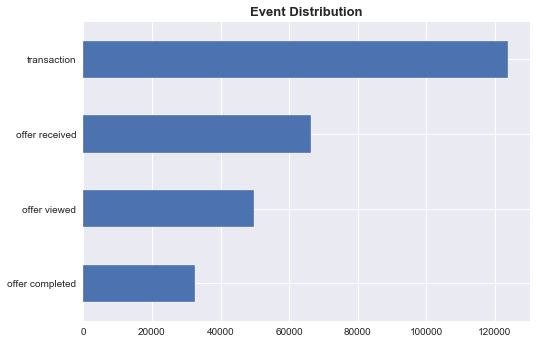

In [57]:
transcript['event'].value_counts(ascending=True).plot(kind="barh")
plt.title("Event Distribution", fontsize=13, weight='bold' );

The plot above shows all events. Almost half of all events were transactions (45%). 24% of events were offer received and the completion  of them represents about half, with 11%.

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ea4">4. Distribution of Offer type</a>

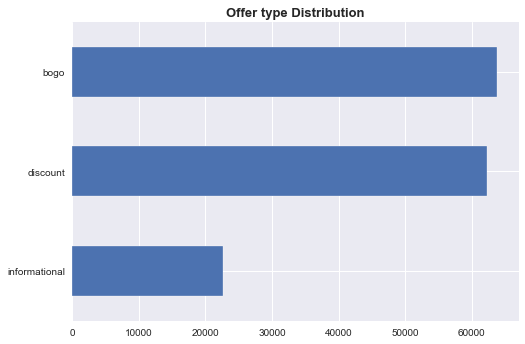

In [58]:
transcript['offer_type'].value_counts(ascending=True).plot(kind="barh")
plt.title("Offer type Distribution", fontsize=13, weight='bold');

The chart exhibits the distribution of offer type. The bogo and discount are very close followed of informational.

Below, **it's created based on df = transcript, the df with offers sent by Starbucks**

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ea5">5. Data Processing: Filter only offer received</a>

In [59]:
offers_sent = transcript[transcript.event == 'offer received']

In [60]:
print(f'A total of {offers_sent.shape[0]} offers were sent to {offers_sent.profile_id.nunique()} users.\n')

A total of 66501 offers were sent to 14820 users.



In [61]:
offers_sent.columns

Index(['event', 'time', 'amount', 'reward', 'offer_type', 'difficulty',
       'duration', 'email', 'mobile', 'social', 'web', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'portfolio_id',
       'gender', 'age', 'became_member_on', 'income', 'gender_F', 'gender_M',
       'gender_O', 'profile_id', 'became_member_on_year', 'days_as_member'],
      dtype='object')

Now, let's set int64 type some columns, which will be used

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ea6">6. Distribution of Offers Received by Each Customer</a>

In [62]:
l_int64 = ['time', 'portfolio_id', 'profile_id']
for i in l_int64:
    offers_sent[i] = offers_sent[i].astype('int64')

<ipython-input-62-8e257a3c8874>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offers_sent[i] = offers_sent[i].astype('int64')


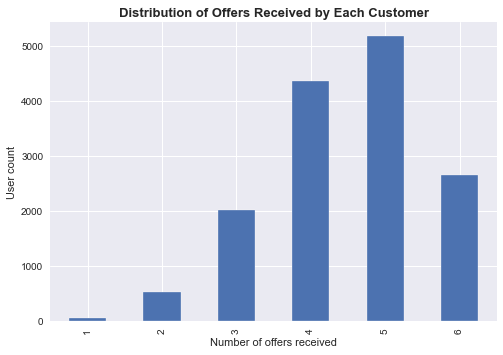

In [63]:
offers_sent.groupby('profile_id').portfolio_id.count().value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Offers Received by Each Customer', fontsize=13, weight='bold')
plt.xlabel('Number of offers received')
plt.ylabel('User count');

In [64]:
max_offers_by_user = offers_sent.groupby('profile_id').portfolio_id.count().max()
print('Maximum number of offers sent by a one customer: {}'.format(max_offers_by_user))

Maximum number of offers sent by a one customer: 6


In [65]:
max_offers_by_user_and_time = offers_sent.groupby(['profile_id', 'time']).portfolio_id.count().max()
print('Maximum number of same offers sent by a one customer at the same time: {}'.format(max_offers_by_user_and_time))

Maximum number of same offers sent by a one customer at the same time: 1


With those prints above, it's portrayed that the time, offer and profile id can be a key to find the events correlated to them in the transcript dataframe.

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ea7">7. Data Processing: Create columns of success or loss of Offers sent</a>

In [66]:
offers_sent['expiration_time'] = offers_sent['time'] + offers_sent['duration']*24
offers_sent['expiration_time'] = offers_sent['expiration_time'].astype('int64')

<ipython-input-66-162d0a257f04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offers_sent['expiration_time'] = offers_sent['time'] + offers_sent['duration']*24
<ipython-input-66-162d0a257f04>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offers_sent['expiration_time'] = offers_sent['expiration_time'].astype('int64')


#### Create columns of sucess - Viewed and Completed

In this part, it will be created the binary columns of offer completed and viewed.

In [68]:
def set_event_time(row, event='offer viewed', transcript=transcript):
    '''
    Loop for each row, looking for the time of the offer sent and returns the time of viewed or completed offer, 
    if the offer wasn't vieweved or completed returns null (np.nan).
    
    INPUT:
    row (pandas series) : row from offers_sent data frame. The loop is making in this dataframe, all values needed to be
                            "row." before the name of column
    event (str) : 'offer viewed' or 'offer completed'
    transcript (data frame) : fact table with all events without filters
    
    OUTPUT:
    time_of_event (float): time of event (completed or viewed) when it's the case, else np.nan
    '''
    

    # Check if there is a register with the key portfolio_id + profile_id inside the maximum duration
    try:
        time_of_event = transcript[((transcript.time >= row.time) & (transcript.time <= row.expiration_time)) #check if there is a value in range of time
                                & (transcript.portfolio_id == row.portfolio_id) #key offer id
                                & (transcript.event == event) & (transcript.profile_id == row.profile_id)].time.values[0] #key user id
                                 
    except:
        time_of_event = np.nan

    return time_of_event

The command below **takes a long time**, because of validations and rules. But, it's very important to have the column with success or not of the viewed and completed actions.

In [69]:
# Add new columns with times when offer sent was viewed and/or completed
offers_sent['time_viewed'] = offers_sent.apply(set_event_time, event='offer viewed', axis=1)
offers_sent['time_completed'] = offers_sent.apply(set_event_time, event='offer completed', axis=1)

<ipython-input-69-bda7b85ce209>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offers_sent['time_viewed'] = offers_sent.apply(set_event_time, event='offer viewed', axis=1)
<ipython-input-69-bda7b85ce209>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offers_sent['time_completed'] = offers_sent.apply(set_event_time, event='offer completed', axis=1)


As we don't have data of completed offers about information. Let's consider the situation, **always the information is followed by a transaction inside of the time of offer and after the user viewed, returns 1 else 0**.

In [70]:
def set_event_time_information_offer(row, transcript=transcript):
    '''
    Loop for each row, looking for one transcation after time of the offer information was sent 
    and returns the time of completed offer, if the offer didn't have a transaction returns null (np.nan).
    
    INPUT:
    row (pandas series) : row from offers_sent data frame. The loop is making in this dataframe, all values needed to be
                            "row." before the name of column
    transcript (data frame) : fact table with all events without filters
    
    OUTPUT:
    (int): time of event completed when it's the case, else np.nan
    '''

    # Check if there were any transactions between offer was viewed and offer duration ended
    try:
        time_of_event = transcript[(transcript.event == 'transaction') & (transcript.profile_id == row.profile_id) 
                      & (transcript.time >= row.time) & (transcript.time <= row.expiration_time)].time.values[0]
        
    except:
        time_of_event = np.nan
    
As we don't have data of completed offers about information. Let's consider the situation, always the information is followed by a transaction inside of the time of offer and after the user viewed, returns 1 else 0.    return time_of_event

In [71]:
filter_information = ((offers_sent.portfolio_id.isin([3,8]))&(offers_sent.time_viewed.notnull()))
offers_sent.loc[filter_information,'time_completed' ] = offers_sent[filter_information].apply(set_event_time_information_offer, axis=1)

c:\users\mathe\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [72]:
offers_sent['success_completed'] = ((offers_sent.time_completed.notnull()) & (offers_sent.time_viewed <= offers_sent.time_completed)).astype(int)
offers_sent['success_viewed'] = ((offers_sent.time_viewed.notnull())).astype(int)

<ipython-input-72-6f30a9efb7fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offers_sent['success_completed'] = ((offers_sent.time_completed.notnull()) & (offers_sent.time_viewed <= offers_sent.time_completed)).astype(int)
<ipython-input-72-6f30a9efb7fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offers_sent['success_viewed'] = ((offers_sent.time_viewed.notnull())).astype(int)


The command above shows how to encode with 1 success event and 0 no success event. 

##### After the work of data engeneering, we can use the metrics of succes and loss offer.

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ea8">8. How many offers were sent out, viewed and completed?</a>

In [73]:
# define variables
success_viewed = offers_sent['success_viewed'].sum()
success_completed = offers_sent['success_completed'].sum()
total_offers = offers_sent.shape[0]

In [74]:
# transform to a dataframe
values= [total_offers,success_viewed,success_completed]
d = {'Total Offers': [total_offers], 'Viewed Success': [success_viewed], 'Completed Success': [success_completed]}
df_summary = pd.DataFrame(data=d, index=['count'])

,Total Offers,Viewed Success,Completed Success
count,66501,49126,27191


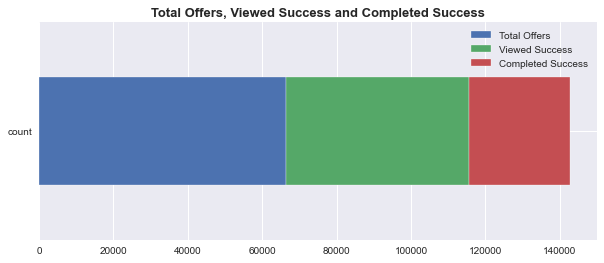

In [75]:
df_summary.plot(kind='barh', figsize=(10, 4), stacked=True)
plt.title('Total Offers, Viewed Success and Completed Success', fontsize=13, weight='bold')
df_summary

In this plot, we can see the distribution of total offers, viewed success and completed success. The **relationship between viewed success and completed success is about half.**

,success_viewed,success_completed
sum,49126.000000,27191.000000
mean,0.738726,0.408881


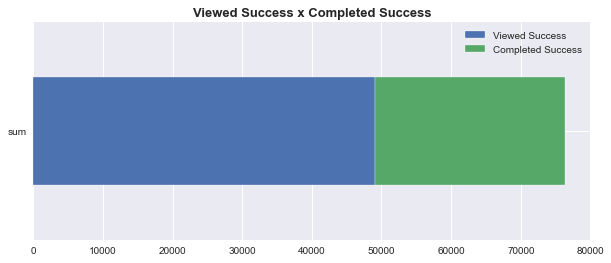

In [76]:
offers_sent.agg({ 'success_viewed': ['sum'], 'success_completed' : ['sum']}).plot(
    kind='barh', figsize=(10, 4), stacked=True)
plt.title('Viewed Success x Completed Success', fontsize=13, weight='bold')
plt.legend(['Viewed Success', 'Completed Success'])
offers_sent.agg({'success_viewed': ['sum', 'mean'], 'success_completed' : ['sum', 'mean']})

This image highlighted the percent of success in comparison with total offers.

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ea9">9.  What type of offer has the best rate of completion?</a>

In [77]:
offers_sent_summary = (offers_sent.groupby('offer_type', as_index=False)
      .agg(
      total_offers = ('success_completed','count'),
      success_viewed_total = ('success_viewed','sum'), 
      success_viewed_pct = ('success_viewed','mean'),
      success_completed_total = ('success_completed','sum'),
      success_completed_pct = ('success_completed','mean'),
      )).set_index('offer_type')

In [78]:
offers_sent_summary = offers_sent_summary.sort_values('success_completed_pct', ascending = False)

In [79]:
offers_sent_summary = offers_sent_summary.reset_index()

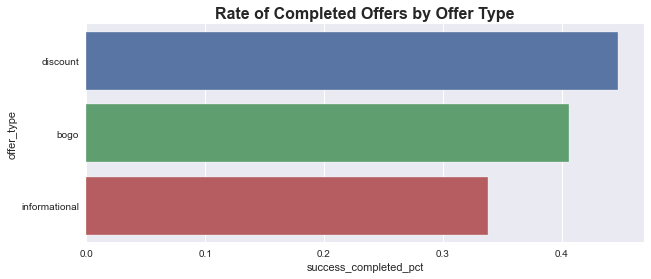

In [80]:
plt.figure(figsize=(10, 4))
plt.title('Rate of Completed Offers by Offer Type', fontsize=16, weight='bold')
sns.barplot(data=offers_sent_summary, x='success_completed_pct', y='offer_type', orient='h');

In [81]:
offers_sent_summary.sort_values('success_completed_pct', ascending = False)

,offer_type,total_offers,success_viewed_total,success_viewed_pct,success_completed_total,success_completed_pct
0,discount,26664,18555,0.695882,11920,0.447045
1,bogo,26537,21969,0.827863,10779,0.406188
2,informational,13300,8602,0.646767,4492,0.337744


Different from the previous question, here we can see better the success for each offer type. As a lot of people have already expected, the **informational type has the worst rate** and discount with best near the buy one get one, called "bogo".

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ea10">10.  What platform has the best rate of completion?</a>

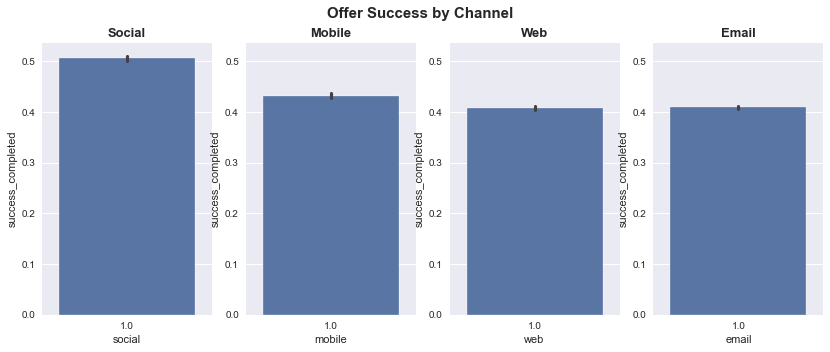

In [82]:
# Visualize success probability grouped by channel
fig, ax = plt.subplots(1, 4, figsize=(14, 5))
fig.suptitle('Offer Success by Channel', fontsize=15, weight='bold')

# social
plt.subplot(1, 4, 1)
ax1 = sns.barplot(data=offers_sent[offers_sent.social==1], x='social', y='success_completed')
ax1.set_title('Social', fontsize=13, weight='bold');

# mobile
plt.subplot(1, 4, 2, sharey=ax1)
ax2 = sns.barplot(data=offers_sent[offers_sent.mobile==1], x='mobile', y='success_completed')
ax2.set_title('Mobile', fontsize=13, weight='bold');

# web
plt.subplot(1, 4, 3, sharey=ax1)
ax3 = sns.barplot(data=offers_sent[offers_sent.web==1], x='web', y='success_completed')
ax3.set_title('Web', fontsize=13, weight='bold');

# email
plt.subplot(1, 4, 4, sharey=ax1)
ax3 = sns.barplot(data=offers_sent[offers_sent.email==1], x='email', y='success_completed')
ax3.set_title('Email', fontsize=13, weight='bold');

**All rates here are near the 50% and 40%**, which seems that this type of feature doesn't make a lot of influence in the success of a coupon.

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ea11">11.  What offer has the best rate of completion?</a>

In [83]:
offers_sent_summary = (offers_sent.groupby('portfolio_id', as_index=False)
      .agg(
      total_offers = ('success_completed','count'),
      success_viewed_total = ('success_viewed','sum'), 
      success_viewed_pct = ('success_viewed','mean'),
      success_completed_total = ('success_completed','sum'),
      success_completed_pct = ('success_completed','mean'),
      )).set_index('portfolio_id') 

In [84]:
offers_sent_summary = pd.merge(offers_sent_summary, portfolio, on='portfolio_id', how='left')

In [85]:
offers_sent_summary = offers_sent_summary.reset_index()
def set_summary(row, df=offers_sent_summary):
    return 'id: '+ str(row.portfolio_id) + ' - '+ row.offer_type + ' - reward: ' + str(row.reward) + ' - difficulty: '+ str(row.difficulty) + ' - duration: ' + str(row.duration)

offers_sent_summary['description'] = offers_sent_summary.apply(set_summary, axis=1)
offers_sent_summary=offers_sent_summary.set_index('portfolio_id') 

In [86]:
offers_sent_summary = offers_sent_summary.sort_values('success_completed_pct', ascending = False)

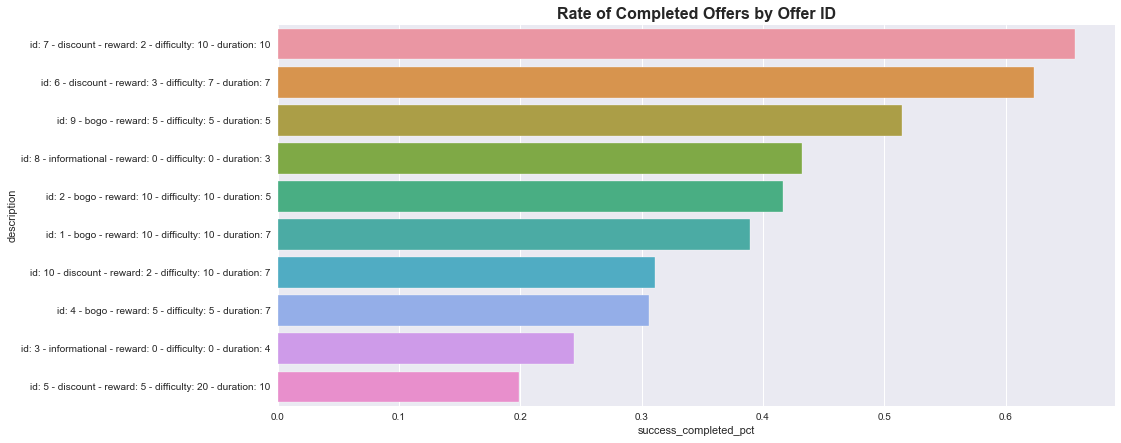

In [87]:
plt.figure(figsize=(15, 7))
plt.title('Rate of Completed Offers by Offer ID', fontsize=16, weight='bold')
sns.barplot(data=offers_sent_summary, x='success_completed_pct', y='description', orient='h');

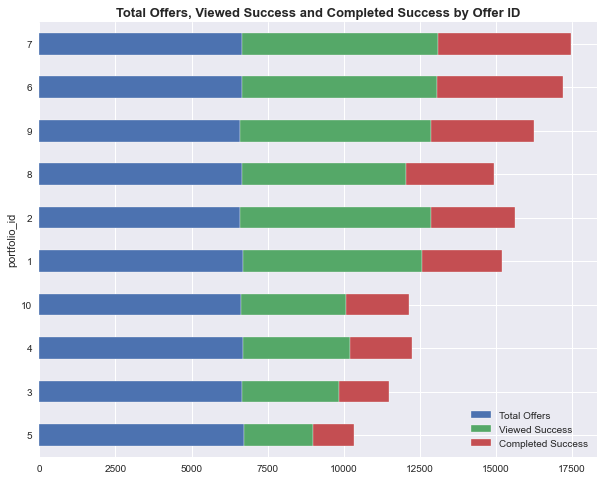

In [88]:
offers_sent_summary = offers_sent_summary.sort_values('success_completed_pct', ascending = True)

offers_sent_summary[['total_offers','success_viewed_total', 'success_completed_total']].plot(
    kind='barh', figsize=(10, 8), stacked=True)
plt.title('Total Offers, Viewed Success and Completed Success by Offer ID', fontsize=13, weight='bold')
plt.legend(['Total Offers','Viewed Success', 'Completed Success']);

In [89]:
offers_sent_summary.drop(columns=['description', 'id']).sort_values('success_completed_pct', ascending = False)

,index,total_offers,success_viewed_total,success_viewed_pct,success_completed_total,success_completed_pct,offer_type,reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
portfolio_id,,,,,,,,,,,,,,,,,
7,6,6652,6433,0.967078,4371,0.657096,discount,2,10,10,1,1,1,1,0,1,0
6,5,6655,6390,0.960180,4146,0.622990,discount,3,7,7,1,1,1,1,0,1,0
9,8,6576,6279,0.954836,3383,0.514446,bogo,5,5,5,1,1,1,1,1,0,0
8,7,6643,5414,0.814993,2869,0.431883,informational,0,0,3,1,1,1,0,0,0,1
2,1,6593,6282,0.952829,2748,0.416806,bogo,10,10,5,1,1,1,1,1,0,0
1,0,6683,5901,0.882987,2602,0.389346,bogo,10,10,7,1,1,1,0,1,0,0
10,9,6631,3457,0.521339,2064,0.311265,discount,2,10,7,1,1,0,1,0,1,0
4,3,6685,3507,0.524607,2046,0.306058,bogo,5,5,7,1,1,0,1,1,0,0
3,2,6657,3188,0.478894,1623,0.243804,informational,0,0,4,1,1,0,1,0,0,1


**As we can see, the best rate is for the promotion id = 7. Discount of 2	and spend 10 with a duration of 10 days. With the table above, it's possible to see the column of success_completed_pct and type of offer, for example.**

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ea12">12.  Data Processing: Create columns of segmentations of Age and Income</a>

#### Create columns of segmentation - Age and Income

In [90]:
profile['age_group'] = pd.qcut(profile.age, 5, labels=range(1, 6)).astype(int)
profile['income_group'] = pd.qcut(profile.income, 5, labels=range(1, 6)).astype(int)

The aim of **those segmentations is to find some patterns**. In the following histograms, we will see if it was useful.

In [91]:
# Left join between user data into event data
offers_with_groups = pd.merge(offers_sent, profile[['age_group','income_group', 'profile_id']], on='profile_id', how='left')

In [92]:
offers_with_groups.head(2)

,event,time,amount,reward,offer_type,difficulty,duration,email,mobile,social,...,profile_id,became_member_on_year,days_as_member,expiration_time,time_viewed,time_completed,success_completed,success_viewed,age_group,income_group
0,offer received,0,0.0,0,bogo,5.0,7.0,1.0,1.0,0.0,...,2,2017,443,168,6.0,132.0,1,1,5,5
1,offer received,0,0.0,0,discount,10.0,7.0,1.0,1.0,0.0,...,3,2018,91,168,18.0,NaN,0,1,4,3


<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ea13">13. Is there any relationship between demographic variables and rate of completion?</a>

###  Age

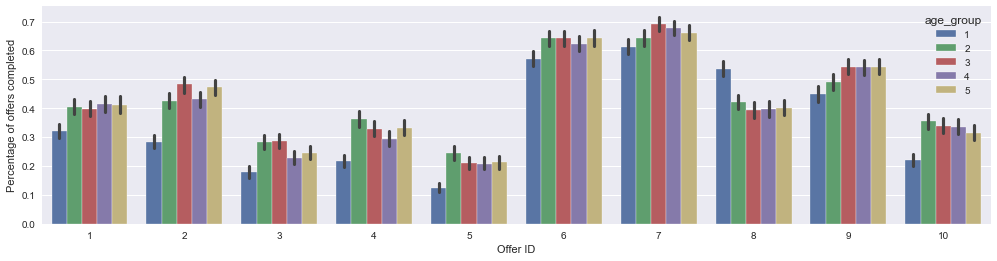

In [183]:
plt.figure(figsize=(17, 4))
sns.barplot(data=offers_with_groups, x='portfolio_id', y='success_completed', hue='age_group')
plt.ylabel('Percentage of offers completed')
plt.xlabel('Offer ID')
plt.show()

### Income

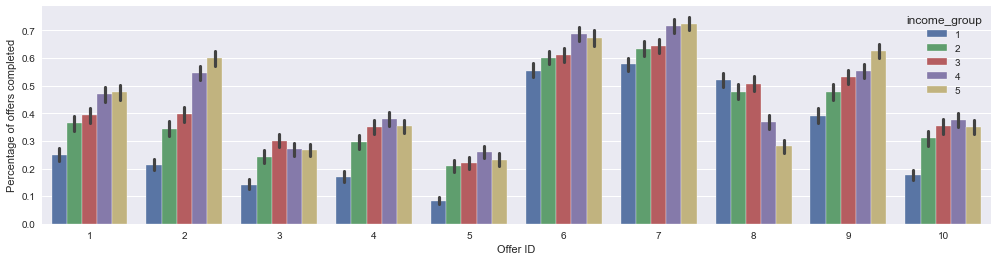

In [184]:
plt.figure(figsize=(17, 4))
sns.barplot(data=offers_with_groups, x='portfolio_id', y='success_completed', hue='income_group')
plt.ylabel('Percentage of offers completed')
plt.xlabel('Offer ID')
plt.show()

### Sign In Year

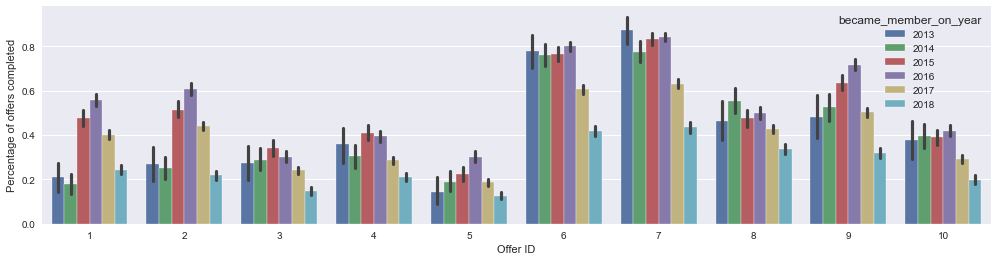

In [185]:
plt.figure(figsize=(17, 4))
sns.barplot(data=offers_with_groups, x='portfolio_id', y='success_completed', hue='became_member_on_year')
plt.ylabel('Percentage of offers completed')
plt.xlabel('Offer ID')
plt.show()

### Gender

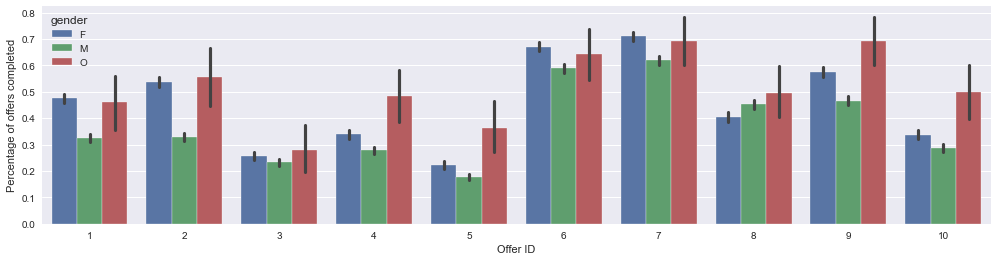

In [186]:
plt.figure(figsize=(17, 4))
sns.barplot(data=offers_with_groups, x='portfolio_id', y='success_completed', hue='gender')
plt.ylabel('Percentage of offers completed')
plt.xlabel('Offer ID')
plt.show()

It's clear the rate of **men is worse than the other and female**.

The sign in year, age and income doesn't show a lot in those graphics. 

<a href='#contents'>**Go to Table of Contents**</a>

## <a id="ml">VI: Build the ML model to predict offer success</a>

### <a id="ml1">1. Data Processing</a>

In [97]:
offers_sent.columns

Index(['event', 'time', 'amount', 'reward', 'offer_type', 'difficulty',
       'duration', 'email', 'mobile', 'social', 'web', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'portfolio_id',
       'gender', 'age', 'became_member_on', 'income', 'gender_F', 'gender_M',
       'gender_O', 'profile_id', 'became_member_on_year', 'days_as_member',
       'expiration_time', 'time_viewed', 'time_completed', 'success_completed',
       'success_viewed'],
      dtype='object')

In [98]:
print('Count of genders: \n{}\n\n'.format(offers_sent.gender.value_counts()))
print('Percentage of genders: \n{}'.format(offers_sent.gender.value_counts(normalize=True)))

Count of genders: 
M    38129
F    27456
O      916
Name: gender, dtype: int64


Percentage of genders: 
M    0.573360
F    0.412866
O    0.013774
Name: gender, dtype: float64


The "other" genre represents a bit more than 1%. Based on that, for improving the model, **we will eliminate this variable as female too, keeping only the male (majority).**

In [99]:
final_offers_ml = offers_sent.drop(columns=['event', 'time','amount','offer_type','portfolio_id', 'became_member_on_year','expiration_time',
       'time_viewed', 'time_completed','success_viewed','profile_id', 'gender', 'gender_F', 'gender_O', 'became_member_on'])

final_offers_ml.head(2)

,reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,age,income,gender_M,days_as_member,success_completed
0,0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,75,100000.0,0,443,1
1,0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,68,70000.0,1,91,0


In [101]:
final_offers_ml.head(2)

,reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,age,income,gender_M,days_as_member,success_completed
0,0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,75,100000.0,0,443,1
1,0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,68,70000.0,1,91,0


In [102]:
X = final_offers_ml.drop(['success_completed'], axis=1)
y = final_offers_ml['success_completed']

X.shape, y.shape

((66501, 14), (66501,))

In [103]:
from sklearn.model_selection import train_test_split

# Split data into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Check size
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((53200, 14), (13301, 14), (53200,), (13301,))

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ml2">2. Modellings</a>

In [104]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import pickle

In [105]:
models = [
    
          {'name': 'svc',
           'clf' : SVC(),
           'params' : {'clf__C' : [1.0],
                       'clf__gamma': [1.0]
                      }
          },
    
          {'name': 'naive_bayes',
           'clf' : GaussianNB(),
           'params' : {'clf__var_smoothing' : [1e-8, 1e-9, 1e-10]
                      }
          },
    
          {'name': 'random_forest',
           'clf' : RandomForestClassifier(),
           'params' : {'clf__criterion' : ['gini', 'entropy'],
                       'clf__n_estimators' : [50, 100],
                       'clf__max_depth' : [6, 10, None],
                       'clf__min_samples_split' : [2, 4, 20, 100],
                       'clf__max_samples': [0.4, 0.6, 0.8, None]
                      }
          }    ,

           {'name': 'gradient_boosting',
           'clf' : GradientBoostingClassifier(),
           'params' : {'clf__loss' : ['deviance', 'exponential'],
                       'clf__n_estimators' : [50, 100, 200],
                       'clf__min_samples_split' : [2, 4, 6]
                      }
           },
    
          {'name': 'logistic_regression',
           'clf' : LogisticRegression(),
           'params' : {'clf__C' : [0.01, 0.1, 1.0, 2.0],
                       'clf__solver' : ['liblinear', 'lbfgs', 'saga', 'newton-cg']
                      }
          },

          {'name': 'knn',
           'clf' : KNeighborsClassifier(),
           'params' : {'clf__n_neighbors' : [3, 5, 7, 10, 20],
                       'clf__weights' : ['uniform', 'distance'],
                       'clf__algorithm' : ['auto', 'ball_tree', 'kd_tree']
                      }
          },

         {'name': 'decision_tree',
           'clf' : DecisionTreeClassifier(),
           'params' : {'clf__criterion' : ['gini', 'entropy'],
                       'clf__splitter' : ['best', 'random'],
                       'clf__max_depth' : [None, 10],
                       'clf__min_samples_split' : [2, 4],
                       'clf__max_features': [0.25, 0.5, 0.75, None],
                      }
          },


]

Here we declared **all models** and parameters will be tested.

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ml3">3. Building the model of ML: pipeline and gridsearch</a>

In [106]:
def build_model(model_dict):
    """
    Responsable for building the model of machine learning. We have here the pipeline and the variables that will be tested
    in de gridsearch
    
    INPUT: None
    OUTPUT: model of machine learning
    """
        
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', model_dict['clf'])
    ])    

    model = GridSearchCV(pipeline, param_grid=model_dict['params'])
    return model

We choose the **Standard Scaler** to normalize the data.

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ml4">4. Evaluating the model</a>

In [107]:
def evaluate_model(model, X_test, Y_test, model_dict,evaluate_metrics):
    """
    Responsable for evaluating the model, with the function of classification_report of skitlearn
    
    INPUT: model(gridsearch), X_test, Y_test and categories names
    OUTPUT: None
    """
    
    predicted = model.predict(X_test)
    
    report = classification_report(Y_test, predicted, output_dict=True)
    report['best_params'] = model.best_params_
    report['name_model'] = model_dict['name'].replace('_', ' ').title()
    evaluate_metrics.append(report)
    print(classification_report(Y_test, predicted))

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ml5">5. Saving the model</a>

In [108]:
def save_model(model, model_dict):
    """
    Saves the model
    
    INPUT: model and model_filepath
    OUTPUT: None
    """
 
    filename = f'models/{model_dict["name"]}.pkl'
    pickle.dump(model, open(filename, 'wb'))

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ml6">6. Running all models</a>

In [109]:
def main():
    """
    Run all functions above in a organized way
    """  
    
    evaluate_metrics = []
    for model_dict in models:
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
        
        print('------------- {} -------------'.format(model_dict['name'].replace('_', ' ').title()))
        print('Building model...')
        model = build_model(model_dict)
        
        print('Training model...')
        model.fit(X_train, Y_train) 
        
        print('Evaluating model...')
        evaluate_model(model, X_test, Y_test, model_dict,evaluate_metrics)

        print('Saving model...')
        save_model(model, model_dict)

        print('Trained model saved!')
        print('\n\n')
    
    df_evaluate_metrics = pd.DataFrame(evaluate_metrics)[['accuracy', 'name_model', 'best_params']]
    
    return df_evaluate_metrics

df_evaluate_metrics = main()

------------- Svc -------------
Building model...
Training model...
Evaluating model...
              precision    recall  f1-score   support

           0       0.70      0.82      0.75      7852
           1       0.65      0.50      0.57      5449

    accuracy                           0.69     13301
   macro avg       0.68      0.66      0.66     13301
weighted avg       0.68      0.69      0.68     13301

Saving model...
Trained model saved!



------------- Naive Bayes -------------
Building model...
Training model...
Evaluating model...
              precision    recall  f1-score   support

           0       0.73      0.52      0.60      7864
           1       0.51      0.72      0.59      5437

    accuracy                           0.60     13301
   macro avg       0.62      0.62      0.60     13301
weighted avg       0.64      0.60      0.60     13301

Saving model...
Trained model saved!



------------- Random Forest -------------
Building model...
Training model...
Eval

After running all models declared before, **Random Forest shows the best accuracy and the others metrics are very similar**. So, let's use it to deploy the ML model.

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ml7">7. Choosing the model</a>

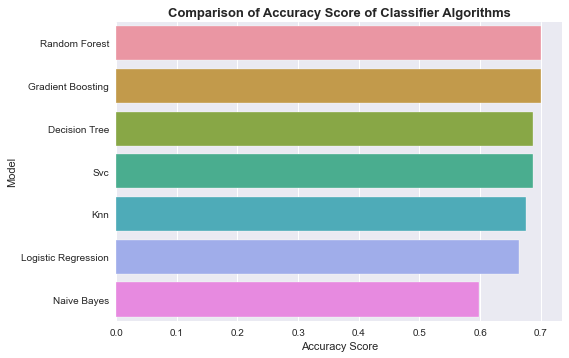

In [179]:
sns.barplot(data=df_evaluate_metrics.sort_values(by = 'accuracy', ascending= False), x='accuracy', y='name_model', orient='h')
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.title('Comparison of Accuracy Score of Classifier Algorithms', fontsize=13, weight='bold');

In [111]:
df_evaluate_metrics.sort_values(by = 'accuracy', ascending= False)

,accuracy,name_model,best_params
2,0.700624,Random Forest,"{'clf__criterion': 'gini', 'clf__max_depth': 1..."
3,0.699647,Gradient Boosting,"{'clf__loss': 'deviance', 'clf__min_samples_sp..."
6,0.687016,Decision Tree,"{'clf__criterion': 'gini', 'clf__max_depth': 1..."
0,0.686790,Svc,"{'clf__C': 1.0, 'clf__gamma': 1.0}"
5,0.675363,Knn,"{'clf__algorithm': 'auto', 'clf__n_neighbors':..."
4,0.664010,Logistic Regression,"{'clf__C': 0.01, 'clf__solver': 'lbfgs'}"
1,0.598677,Naive Bayes,{'clf__var_smoothing': 1e-08}


In [144]:
# Load trained gradient boosting classifier
filepath = 'models/random_forest.pkl'
with open(filepath, 'rb') as file:
    clf = pickle.load(file)

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ml8">8. Feature Importance</a>

In [145]:
from sklearn.inspection import permutation_importance

# feature of weights
result = permutation_importance(clf, X_train, y_train, n_repeats=10)
feature_weights = pd.Series(result.importances_mean, index=[ i.replace('_', ' ').title() for i in X.columns]
                           ).sort_values(ascending=False)

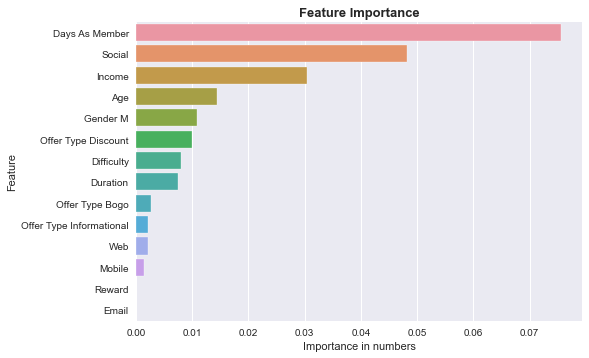

In [146]:
# Display feature importance
sns.barplot(x=feature_weights, y=feature_weights.index)
plt.title('Feature Importance', fontsize=13, weight='bold')
plt.xlabel('Importance in numbers')
plt.ylabel('Feature');

In [147]:
feature_weights

Days As Member              0.075555
Social                      0.048180
Income                      0.030421
Age                         0.014391
Gender M                    0.010910
Offer Type Discount         0.009991
Difficulty                  0.008058
Duration                    0.007453
Offer Type Bogo             0.002782
Offer Type Informational    0.002218
Web                         0.002173
Mobile                      0.001432
Reward                      0.000000
Email                       0.000000
dtype: float64

<a href='#contents'>**Go to Table of Contents**</a>

### <a id="ml9">9. Probability Offer Success</a>

In [148]:
def predict_success_probabilities(user_id, clf=clf, portfolio=portfolio, profile=profile):
    '''
    Predicts success probabilities for all offers types of a user_id.
    
    INPUT:
    user_id (str) : USER ID of a customer created in data processing
    clf (trained classifier) : classification model 
    portfolio (data frame) : containing offer ids and meta data about each offer (duration, type, etc.)
    profile (data frame) : demographic data for each customer
    
    OUTPUT:
    probability_of_success (list) : list of success probabilities
    '''
    
    probability_of_success = []

    # Get profile features
    profile_filtered = profile[profile.profile_id == user_id].drop(columns=['gender', 'profile_id', 'id', 'became_member_on'
                                                            ,'gender_F', 'gender_O', 'age_group', 'became_member_on_year'
                                                            ,'income_group']).squeeze()
    
    # loop for each offer type
    for row in portfolio.drop(columns=['portfolio_id', 'offer_type', 'id']).iterrows():
        try:
            # Get portfolio features
            offer_data = list(row)[1]
            
            # Union of profile and offer features
            X = offer_data.append(profile_filtered)
            X = np.array(X).reshape(1, -1)
            
            # Predicts the proability of succesful
            probability_of_success.append(clf.predict_proba(X)[0][1])
        except:
            probability_of_success.append(np.nan)
    
    return probability_of_success

In [155]:
def get_users_probs(users, portfolio=portfolio):
    '''
    Builds a data frame with the success probabilities for all offers. 
    The columns are the offers_ids and the rows are the users_ids.
    
    INPUT:
    users (list) : list of customer IDs
    portfolio (data frame) : containing offer ids and meta data about each offer (duration, type, etc.)
    
    OUTPUT:
    df_probability_of_success (data frame) : data frame with the success probabilities
    '''
    
    # Get probabilites of a user list
    data_probs = list(pd.Series(users).apply(predict_success_probabilities))
    
    # Create data frame with offer_ids as columns and customer_ids as rows
    df_probability_of_success = pd.DataFrame(data_probs, columns=portfolio.portfolio_id, index=users)
    
    return df_probability_of_success

In [178]:
from random import randint, sample
last_user = profile.profile_id.max()
users = sample(range(1, last_user+1), 10) # creates a list of 10 numbers between the last and first user
get_users_probs(users)

portfolio_id,1,2,3,4,5,6,7,8,9,10
148,0.314811,0.322556,0.224381,0.261064,0.198462,0.503741,0.530033,0.434842,0.376442,0.277157
12909,0.204470,0.176088,0.106227,0.145044,0.105216,0.393819,0.365718,0.479570,0.271564,0.142636
7967,0.211285,0.165277,0.117426,0.164564,0.090073,0.372075,0.359971,0.384568,0.262137,0.088236
10228,0.257468,0.252514,0.197406,0.221748,0.115594,0.419057,0.487929,0.408466,0.339400,0.278620
7868,0.579600,0.675472,0.365435,0.477805,0.316876,0.766956,0.835847,0.374724,0.718845,0.496876
1994,0.336181,0.359269,0.213718,0.269279,0.180493,0.503718,0.560449,0.395571,0.404916,0.264260
6833,0.583235,0.666509,0.435484,0.494760,0.366804,0.795242,0.840960,0.369164,0.700600,0.503260
11983,0.536171,0.554606,0.362241,0.466240,0.326987,0.777540,0.838552,0.571370,0.667796,0.515020
8335,0.529234,0.575224,0.383240,0.453962,0.331754,0.778316,0.861736,0.611494,0.674122,0.476351
11679,0.545986,0.624894,0.368664,0.474557,0.350903,0.815976,0.838489,0.413179,0.682209,0.512408


<a href='#contents'>**Go to Table of Contents**</a>

## <a id="summ">VII: Conclusion</a>

In this notebook, we can build a **model of probability of an offer having success**, with accuracy of 70% with Random Forest.

Predicting the probability of an offer is a case that could be applied in all companies to increase their sales.

So, this model could be tested with a **test A/B.** So, half of the users might have a metric about under 40% of success, we don't send, and without any rule, just sending as it seems today.

Based on that, the ratings with a low value, otherwise, the customer have a low chance to accepted the coupon, the company wouldn't send. **Because the chance is low, and maybe they ignore other promotions because they are denied notifications of promotions that don't interest them.**

Talking about feature importance, **"days as member", "social" and "income"** are the most important for the model.

<a href='#contents'>**Go to Table of Contents**</a>